In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
        # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices('GPU')
                print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
        # Memory growth must be set before GPUs have been 
             print(e)

init_gpu()

1 Physical GPUs, 1 Logical GPUs


# 1. 데이터셋 구성하기

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

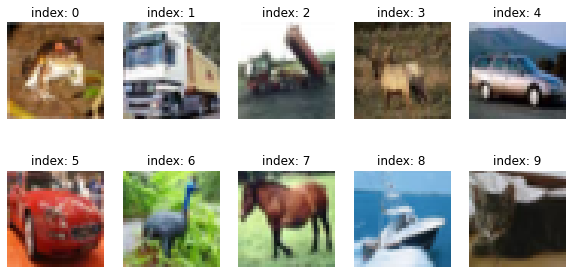

In [4]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i], cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [5]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

In [6]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 2. 생성자 모델 구현하기
- (32, 32, 3)의 shape를 가진 이미지를 생성하는 생성자 모델 구현 함수를 작성해 봅시다.
- noise = tf.random.normal([1, 100])로 생성된 랜덤 노이즈를 입력으로 하여 방금 구현한 생성자로 랜덤 이미지를 생성해 봅시다.
- 생성된 랜덤 이미지가 생성자 출력 규격에 잘 맞는지 확인해 봅시다

In [7]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*128, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 128)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

`Conv2DTranspose`는 업스케일링에 많이 쓰인다. 원본 코드는 (7, 7, 256) → (14, 14, 64) → (28, 28, 1) 으로 크기를 2배씩 키우는 것에 착안해 첫 시작을 (8,8)으로 시작했다. (다만 차원을 좀 낮췄는데, 혹시나 메모리 제한이 걸릴까 싶어서 128차원의 레이어로 시작했다.) 
LeakyReLU는 중간의 값이 폭발하는 것을 막고, tanh는 값을 처음에 -1, 1로 수렴하게 데이터를 처리했기 때문에 tanh로 데이터를 -1, 1 사이로 정규화해준다. 

In [8]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8192)              819200    
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8192)              0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         409600    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [9]:
noise = tf.random.normal([1, 100])
print(noise)
tf.config.experimental_run_functions_eagerly(True)

tf.Tensor(
[[-7.90723041e-02 -2.70407289e-01  1.13558054e-01 -1.42136693e+00
  -1.30477548e+00  3.65434587e-01  1.45567334e+00 -3.33434165e-01
  -7.23211467e-01 -5.79315960e-01  1.10515440e+00  2.27662992e+00
  -8.67948085e-02 -3.10870796e-01 -6.73053086e-01  1.49280274e+00
  -7.13237464e-01 -4.37500864e-01  1.37470528e-01 -6.73436344e-01
  -8.71036649e-01 -1.88333166e+00 -3.57732326e-01  1.42826569e+00
   7.54138589e-01 -7.86611378e-01 -9.07748997e-01  1.62276399e+00
  -7.30385423e-01 -1.71303630e+00  1.02014637e+00 -3.21701860e+00
   9.79204953e-01  1.27740467e+00  1.73534775e+00  2.15274334e+00
   7.07846522e-01  3.38482946e-01 -1.29143512e+00  4.93558943e-01
  -3.55268300e-01  2.11733744e-01  5.62513232e-01 -1.49927810e-02
  -1.06808031e+00 -1.14023280e+00 -1.62900174e+00 -5.06251931e-01
   5.05144536e-01  1.52884436e+00 -1.16668999e+00 -6.88823164e-02
   1.11287586e-01  1.03849006e+00 -2.69256979e-01  1.80515063e+00
   7.97001064e-01  2.62552691e+00  5.28347850e-01  1.60826743e-01

In [10]:
print(noise.shape)

(1, 100)


In [11]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

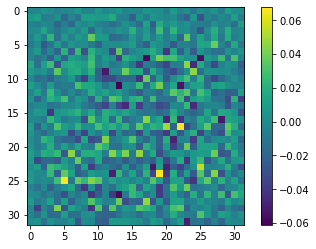

In [12]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

## 구분자 만들기

In [13]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model


구분자는 입력값을 받으면 이미지가 '진짜'인지 아닌지 구분하는 역할을 할 것이다. 그래서 여기서는 입력을 이미지로 받고, 출력을 예, 아니오로 내보내게 된다.(숫자) 그래서 여러 층의 Conv2D 레이어를 거치면서 이미지는 (32,32,3)->(16,16,64)->(8,8,128)->(8192,)->(1,)로 변화한다. 마지막에 Dense 레이어를 거치면서 값을 하나로 수렴한다. 

In [14]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [15]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00091208]], dtype=float32)>

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## 손실함수
해당 모델은 '분류'에 속하고, 2종류의 클래스를 분류하게 된다. 따라서 크로스 엔트로피, 나아가 2진 크로스 엔트로피를 사용한다. 다만 입력값을 `0~1` 사이로 정하기 때문에 입력값을 넣으면 안에서 sigmoid 함수를 사용해 0~1로 정규화하는 옵션을 사용한다. (`from_logits=True`) 손실함수의 값은 각각 0.5가 나와서 합이 1에 가까운 것이 이상적이다. 

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [18]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [23]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [24]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/fashion/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [25]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [26]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [27]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

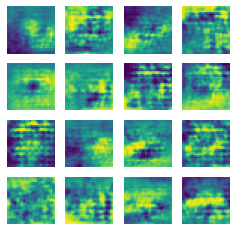

Time for training : 1695 sec


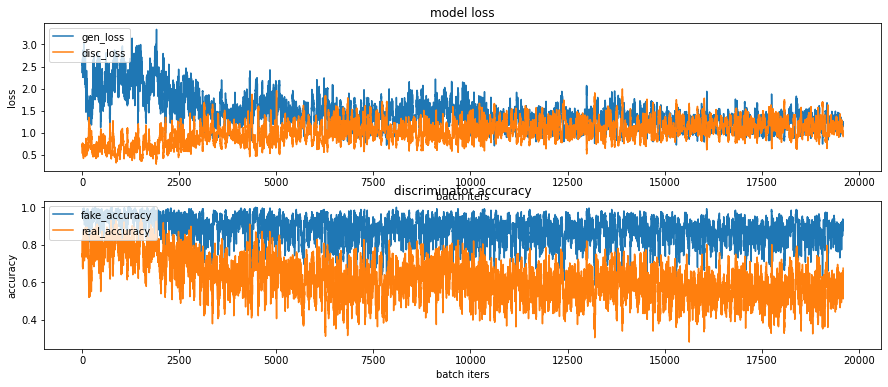

CPU times: user 19min 39s, sys: 43.3 s, total: 20min 23s
Wall time: 28min 16s


In [30]:
%%time
train(train_dataset, EPOCHS, save_every)

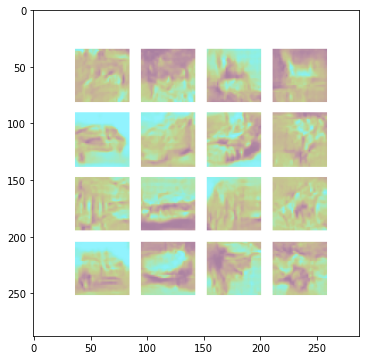

In [51]:
import matplotlib.image as mpimg
import cv2
image = mpimg.imread('/home/aiffel-dj15/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_1000_iter_001.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
pixels = np.array(image)
plt.imshow(((pixels* 127.5) + 127.5).astype(int))
#print(pixels)
#plt.imshow(pixels)
#plt.show()


맨 마지막에 생성된 이미지를 RGB로 돌려서 출력해보았다.(이전에 1000번 돌린 이미지를 첨부함) 그런데 어떤 형태를 가졌다고는 보이지 않아서, 좀 더 개선할 점이 필요해 보인다. 어떻게 개선해 볼까. 아. 실컷 이미지 저장했더니 정규화된 이미지를 원래대로 돌려서 저장해야 하는 것을 그대로 저장해서 색깔이 매우 구리게 나왔다. 

In [52]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        #plt.imshow(predictions[i, :, :, 0])
        plt.imshow(((predictions[i].numpy()* 127.5) + 127.5).astype(int))
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

좀 더 공격적으로 학습해보기 위해서 dropout을 0.5로 올리고 learning rate를 2배로 주겠다. epoch는 200으로 줄 것이다.

In [53]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.3163323]], dtype=float32)>

In [54]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/fashion/training_checkpoints2'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [55]:
save_every = 5
EPOCHS = 200

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

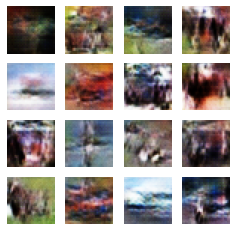

Time for training : 3492 sec


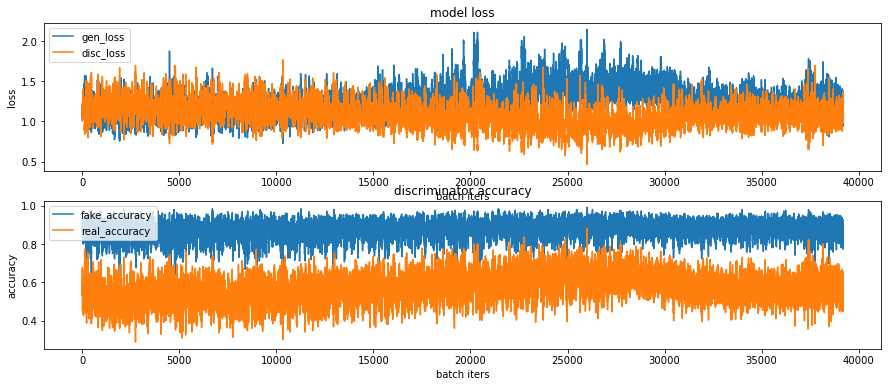

CPU times: user 40min 34s, sys: 1min 31s, total: 42min 6s
Wall time: 58min 14s


In [56]:
%%time
train(train_dataset, EPOCHS, save_every)

돌려놓고 보니 사실 dropout만 조정했는데 이전에 돌린 경우와 그래프 시작점이 다르다. loss의 경우 1/2 줄어든 시점에서 시작하고 있고, accuracy의 경우는 별 다른 차이점이 없다.(real_accuracy가 안좋아졌다..)
그리고 한두장 정도는 말/차/돌고래 등의 비슷한 모양을 보이는 것을 볼 수 있다. (어느 장인지는 마음의 눈으로 보세요)

# 회고
시간이 없어서 다양한 시도를 해보지 못한 것이 아쉽다.